In [1]:
import sys, os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

import data_paths
import cifar10, inception
from inception import transfer_values_cache
from food import food_labels, food_examples


In [2]:
print inception.data_dir
path_graph_def = "classify_image_graph_def.pb"
model_path = os.path.join(inception.data_dir, path_graph_def)
print model_path

/Users/ulzee/dev/ml/_data/inception/model/
/Users/ulzee/dev/ml/_data/inception/model/classify_image_graph_def.pb


In [3]:
import tensorflow as tf
graph = tf.Graph()

# Set the new graph as the default.
with graph.as_default():

# TensorFlow graphs are saved to disk as so-called Protocol Buffers
# aka. proto-bufs which is a file-format that works on multiple
# platforms. In this case it is saved as a binary file.

    # Open the graph-def file for binary reading.
    with tf.gfile.FastGFile(model_path, 'rb') as file:
        # The graph-def is a saved copy of a TensorFlow graph.
        # First we need to create an empty graph-def.
        graph_def = tf.GraphDef()

        # Then we load the proto-buf file into the graph-def.
        graph_def.ParseFromString(file.read())

        # Finally we import the graph-def to the default TensorFlow graph.
        tf.import_graph_def(graph_def, name='')

Now `graph` holds the packaged Inception model from the proto-buf file. Below, we recall various names of nodes in Inception so that we can retrieve them from the graph.

In [4]:
# Name of the tensor for feeding the input image as jpeg.
tensor_name_input_jpeg = "DecodeJpeg/contents:0"

# Name of the tensor for feeding the decoded input image.
# Use this for feeding images in other formats than jpeg.
tensor_name_input_image = "DecodeJpeg:0"

# Name of the tensor for the resized input image.
# This is used to retrieve the image after it has been resized.
tensor_name_resized_image = "ResizeBilinear:0"

# Name of the tensor for the output of the softmax-classifier.
# This is used for classifying images with the Inception model.
tensor_name_softmax = "softmax:0"

# Name of the tensor for the unscaled outputs of the softmax-classifier (aka. logits).
tensor_name_softmax_logits = "softmax/logits:0"

# Name of the tensor for the output of the Inception model.
# This is used for Transfer Learning.
tensor_name_transfer_layer = "pool_3:0"

In [5]:
# Get the output of the Inception model by looking up the tensor
# with the appropriate name for the output of the softmax-classifier.
y_pred = graph.get_tensor_by_name(tensor_name_softmax)

# Get the unscaled outputs for the Inception model (aka. softmax-logits).
y_logits = graph.get_tensor_by_name(tensor_name_softmax_logits)

# Get the tensor for the resized image that is input to the neural network.
resized_image = graph.get_tensor_by_name(tensor_name_resized_image)

# Get the tensor for the last layer of the graph, aka. the transfer-layer.
transfer_layer = graph.get_tensor_by_name(tensor_name_transfer_layer)

# Get the number of elements in the transfer-layer.
transfer_len = transfer_layer.get_shape()[3]

# Create a TensorFlow session for executing the graph.
session = tf.Session(graph=graph)

In [6]:
def _create_feed_dict(image_path, image=None):
    if image is not None:
        # Image is passed in as a 3-dim array that is already decoded.
        feed_dict = {tensor_name_input_image: image}

    elif image_path is not None:
        # Read the jpeg-image as an array of bytes.
        image_data = tf.gfile.FastGFile(image_path, 'rb').read()

        # Image is passed in as a jpeg-encoded image.
        feed_dict = {tensor_name_input_jpeg: image_data}

    else:
        raise ValueError("Either image or image_path must be set.")

    return feed_dict

In [7]:
def classify(image_path):
    # Create a feed-dict for the TensorFlow graph with the input image.
    feed_dict = _create_feed_dict(image_path)

    # Execute the TensorFlow session to get the predicted labels.
    pred = session.run(transfer_layer, feed_dict=feed_dict)

    # Reduce the array to a single dimension.
    pred = np.squeeze(pred)

    return pred

In [8]:
# print(tf.__version__)
# image_path = os.path.join('/Users/ulzee/dev/ml/tutorials/inception/', 'parrot_cropped1.jpg')
# print image_path
labels = food_labels()
batch = food_examples(labels[0])
pred = classify(batch[0].path)
# print labels
# pred = classify(image_path)
print pred.shape

(2048,)


In [9]:
def aspatch(flatarr):
    ln = len(flatarr)
    width = int(np.ceil(np.sqrt(ln)))
    patch = np.zeros((width, width))
    for yy in range(width):
        for xx in range(width):
            flatindex = yy * width + xx
            if flatindex < ln:
                patch[yy][xx] = flatarr[flatindex]
    return patch

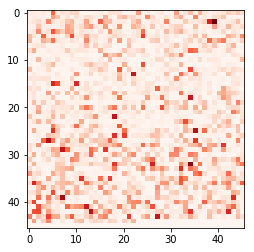

In [10]:
plt.imshow(aspatch(pred), interpolation='nearest', cmap='Reds')
plt.show()

In [42]:
images = []
for one in labels:
    images.append(food_examples(one, load_images=False, limit=50))
layer_data = []
data_labels = []

for ii, batch in enumerate(images[:20]):
#     fPath = os.path.join('/Users/ulzee/dev/ml/tutorials/inception/', fName)
#     imageFiles = os.listdir(fPath)
#     for imageName in imageFiles:
    assert len(batch) == 50
    for example in batch:
        lifted_values = classify(example)
        layer_data.append(lifted_values)
#         print lifted_values[0]
    print 'Loaded data %d/%d - %s' % (ii + 1, len(images), labels[ii].name)
#     break
#         data_labels.append(ii)
#         print lifted_values[1024], imgPath
#         plt.imshow(aspatch(lifted_values), interpolation='nearest', cmap='Reds')
#         plt.show()

Loaded data 1/256 - rice
Loaded data 2/256 - eels on rice
Loaded data 3/256 - pilaf
Loaded data 4/256 - chicken-'n'-egg on rice
Loaded data 5/256 - pork cutlet on rice
Loaded data 6/256 - beef curry
Loaded data 7/256 - sushi
Loaded data 8/256 - chicken rice
Loaded data 9/256 - fried rice
Loaded data 10/256 - tempura bowl
Loaded data 11/256 - bibimbap
Loaded data 12/256 - toast
Loaded data 13/256 - croissant
Loaded data 14/256 - roll bread
Loaded data 15/256 - raisin bread
Loaded data 16/256 - chip butty
Loaded data 17/256 - hamburger
Loaded data 18/256 - pizza
Loaded data 19/256 - sandwiches
Loaded data 20/256 - udon noodle


In [44]:
data_labels = []
for ii, batch in enumerate(images[:20]):
    for example in batch:
        data_labels.append(ii)

In [45]:
pca = PCA(n_components=2)
pca_values = pca.fit_transform(layer_data)
pca_values.shape

(1000, 2)

In [97]:
import matplotlib.cm as cm

def plot_scatter(values, label_indices, labels_count):
    # Create a color-map with a different color for each class.

#     print label_indices
    print values.shape
    cmap = cm.rainbow(np.linspace(0.0, 1.0, labels_count))

    # Get the color for each sample.
    colors = cmap[label_indices]
    label_names = []
    for ind in label_indices:
        label_names.append(labels[ind].name)

    # Extract the x- and y-values.
    values = np.array(values)
    
    plt.figure(figsize=(10,10))
    prev_ind = None
    running_group = []
    for (ii, pair) in enumerate(values):
        ind = label_indices[ii]
        if prev_ind != ind:
            if prev_ind is not None:
                xs, ys = zip(*running_group)
                plt.scatter(list(xs), list(ys), color=cmap[ind], label=labels[ind].name)
            prev_ind = ind
            running_group = []
        running_group.append(pair)
    plt.legend()
    plt.show()

(1000, 2)


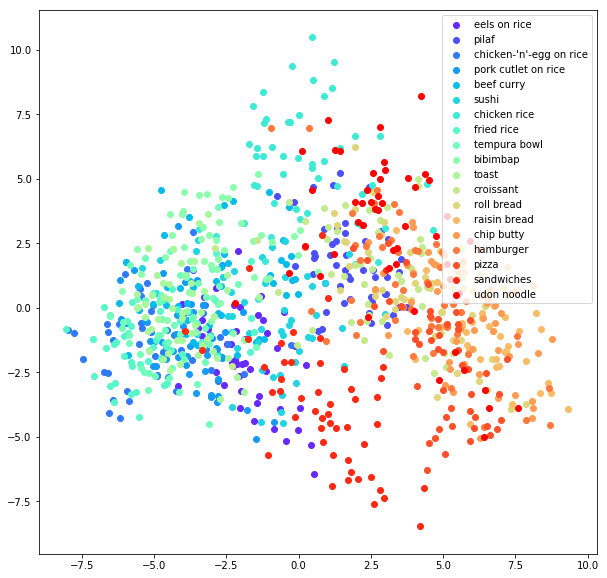

In [98]:
plot_scatter(pca_values, data_labels, 20)